# Отчет 
## Графовые нейронные сети на базе слов для решения задачи Page Layout Analysis

**Задача**: Кратко сформулировать, какую проблему решает новая архитектура.

**Гипотеза**: Какие предположения лежат в основе нового подхода?

**Ожидания**: Какие улучшения предполагаются (скорость, точность, устойчивость и т. д.)?


Нужно где-то сказать про GLAM, и что она решает две задачи.

### Метрика качества
- F1 @ WordIoU [0.5, 0.95]
- mAP @ IoU [0.50:0.95]
- time

$$WordIoU = \frac{WordI}{WordU}$$

$WordI$-число слов в пересекающейся области

$WordU$-число слов в объединенной области

# Текущая SOTA на данных метриках (200 из val publaynet) 

|model|F1 WordIoU 0.50/0.95 | mAP @IoU [0.50:0.95] | time (file/sec)|
|-----|---------------------|----------------------|----------------|
| VGT |0.9985/0.8613        | 0.8713               |0.5792


# Локальные эксперименты
Локальные эксперименты проводятся на 1000 документах из train и нужны для качетсвенной оценки подходов

Тестирование серий происходит на 50 файлах

In [4]:
import re
import matplotlib.pyplot as plt

def extract_metrics_from_file(file_content):
    """
    Извлекает метрики F1 (IoU=0.50 и IoU=0.95), mAP и время из текста файла.
    
    Args:
        file_content (str): Содержимое файла с метриками.
    
    Returns:
        dict: Словарь с извлеченными метриками.
            {
                "F1_0.50": float,
                "F1_0.95": float,
                "mAP": float,
                "time": float
            }
    """
    metrics = {
        "F1_0.50": None,
        "F1_0.95": None,
        "mAP": None,
        "time": None
    }
    
    # Извлекаем F1 (IoU=0.50)
    f1_50_match = re.search(r"F1 \(IoU=0\.50\):\s+([0-9.]+)", file_content)
    if f1_50_match:
        metrics["F1_0.50"] = float(f1_50_match.group(1))
    
    # Извлекаем F1 (IoU=0.95)
    f1_95_match = re.search(r"F1 \(IoU=0\.95\):\s+([0-9.]+)", file_content)
    if f1_95_match:
        metrics["F1_0.95"] = float(f1_95_match.group(1))
    
    # Извлекаем mAP
    map_match = re.search(r"mAP@IoU\[0\.50:0\.95\]\s*=\s*([0-9.]+)", file_content)
    if map_match:
        metrics["mAP"] = float(map_match.group(1))
    
    # Извлекаем время
    time_match = re.search(r"mean time:\s+([0-9.]+)\s*sec", file_content)
    if time_match:
        metrics["time"] = float(time_match.group(1))
    
    return metrics

def read_res_test(header, name):
    with open(f'{header}/{name}/test_result.txt') as f:
         return extract_metrics_from_file(f.read())

### Exp 1. (balans)
Число классов в данных не равномерное. Это относится как к классификации, так и сегментации. Первый эксперимент направлен на выявление значимости балансировки.



In [5]:
print("exp \t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_no', '02_yes', '03_heuristics']:
    print(obj if len(obj) <7 else obj[:7], end='\t')
    r = read_res_test('exp_01_balans', obj)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 	 F1_0.50 	 F1_0.95 	 mAP
01_no	0.06703911	0.02607076	0.00280959
02_yes	0.43516484	0.21978022	0.04507464
03_heur	0.41666667	0.19594595	0.04974618


### Exp 2. (Edge loss + Node loss)
Исходная модель направлена на решение сразу двух задач. Из архитектуры видно, что задача классификации решается раньше сегментации. Поэтому возникает вопрос, а если решать задачу только сегментации, необходимо ли включать в функцию потерь составляющую для классификации и если да, то в каком соотношение с loss для сегментации.

$$Loss=\alpha Loss_{node} + (1-\alpha) Loss_{edge}$$

exp 	 F1_0.50 	 F1_0.95 	 mAP
01_005	0.24371859	0.1080402	0.01573642
02_025	0.39004149	0.19294606	0.04026176
03_050	0.43516484	0.21978022	0.04627727
04_075	0.50996852	0.28751312	0.06863078
05_095	0.44060914	0.24771574	0.05102152


Text(0.5, 0, 'a')

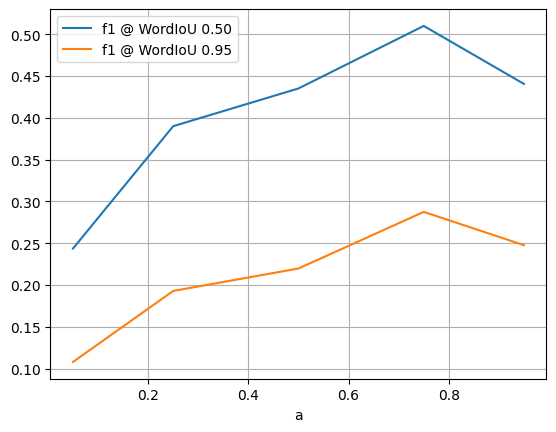

In [6]:

rez = []
t = [0.05, 0.25, 0.50, 0.75, 0.95]
print("exp \t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_005', '02_025', '03_050', '04_075', '05_095']:
    print(obj, end='\t')
    r = read_res_test('exp_02_complex_loss', obj)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')
    rez.append(r)

f1_50 = [r['F1_0.50'] for r in rez]
f1_95 = [r['F1_0.95'] for r in rez]

plt.grid()
plt.plot(t, f1_50, label="f1 @ WordIoU 0.50")
plt.plot(t, f1_95, label="f1 @ WordIoU 0.95")
plt.legend()
plt.xlabel('a')

### Exp 3. (count Tag)
Число слоев может отличаться, поскольку слов в документе на много больше, чем строк.

In [8]:
print("exp \t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_2', '02_3', '03_4']:
    print(obj if len(obj) <7 else obj[:7], end='\t')
    r = read_res_test('exp_03_countTag', obj)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 	 F1_0.50 	 F1_0.95 	 mAP
01_2	0.48877805	0.25685786	0.06323881
02_3	0.44444444	0.23662551	0.04956659
03_4	0.47193347	0.26195426	0.05921496


### Exp 4. (k-глубина)
В работе у слоев tag стоит k=3, варианты 1-6.

In [9]:
print("exp \t F1_0.50 \t F1_0.95 \t mAP")
rez = []
for i, obj in enumerate(['01_1', '02_2', '03_3', '04_4', '05_5', '06_6']):
    print(obj if len(obj) <7 else obj[:7], end='\t')
    r = read_res_test('exp_04_kTag', obj)
    r['k'] = i+1
    rez.append(r)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 	 F1_0.50 	 F1_0.95 	 mAP
01_1	0.46171694	0.21113689	0.0499564
02_2	0.4832636	0.25313808	0.06162456
03_3	0.44444444	0.23662551	0.04988375
04_4	0.43086172	0.23446894	0.05117198
05_5	0.44208494	0.23938224	0.05620339
06_6	0.47413793	0.26508621	0.06108145


Text(0.5, 0, 'a')

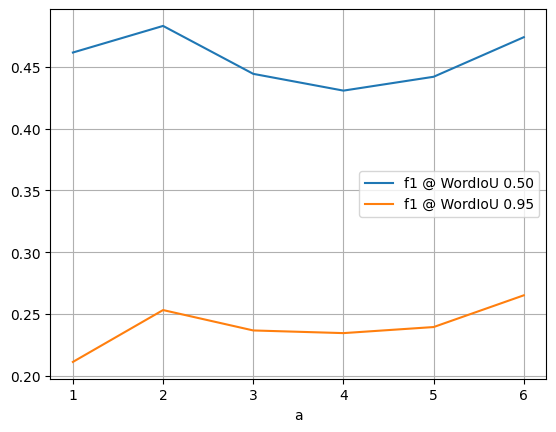

In [10]:
f1_50 = [r['F1_0.50'] for r in rez]
f1_95 = [r['F1_0.95'] for r in rez]
t = [r['k'] for r in rez]
plt.grid()
plt.plot(t, f1_50, label="f1 @ WordIoU 0.50")
plt.plot(t, f1_95, label="f1 @ WordIoU 0.95")
plt.legend()
plt.xlabel('a')

### Exp 5. (батч-нормализация)
В работе стоит две батч нормализации.Но может где-то она не нужна.

In [11]:
print("exp \t\t\t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_node_no_edge_no', '02_node_yes_edge_no', '03_node_no_edge_yes', '04_node_yes_edge_yes']:
    print(obj, end='\t')
    r = read_res_test('exp_05_batchNorm', obj)
    r['k'] = i+1
    rez.append(r)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 			 F1_0.50 	 F1_0.95 	 mAP
01_node_no_edge_no	0.41070234	0.23946488	0.05982726
02_node_yes_edge_no	0.42975207	0.20752984	0.04441968
03_node_no_edge_yes	0.46351085	0.234714	0.05281913
04_node_yes_edge_yes	0.43736264	0.21758242	0.0453898


# Plot Document

In [5]:
import os
import matplotlib.pyplot as plt
os.environ['DEVICE'] = "cpu"
os.environ['JAR_PDF_PARSER'] = '../../java/ispras_tbl_extr.jar'
import importlib
import matplotlib.pyplot as plt
from pager.page_model.sub_models.converters import PDF2Img
from pager.page_model.sub_models.pdf_model import PDFModel
from pager.page_model.sub_models.image_model import ImageModel
from pager.page_model.sub_models.dtype import ImageSegment


EXPERIMENT = "exp_00_base"
exp = importlib.import_module(f"{'.'.join(EXPERIMENT.split('/'))}")

TorchModel = exp.TorchModel
GLAM_MODEL = os.path.join(EXPERIMENT, os.environ["GLAM_MODEL"])
LOG_FILE = os.path.join(EXPERIMENT, "log.txt")

def get_final_model():
    conf = exp.EXPERIMENT_PARAMS
    conf['path_model'] = GLAM_MODEL
    return exp.get_img2phis(conf)

model = get_final_model()
pdf = PDFModel()
img = ImageModel()
pdf2img = PDF2Img()

def plot_file(path_pdf, class_=False):
    model.read_from_file(path_pdf)
    pdf.read_from_file(path_pdf)
    pdf2img.convert(pdf, img)
    model.extract()

    plt.figure(dpi=200)
    plt.subplot(1, 2, 1)
    img.show()

    A = model.page_units[0].sub_model.json["A"]
    words = model.page_units[0].sub_model.json["words"]
    segs = [ImageSegment(dict_2p=w['segment']) for w in words]
    # for seg in segs:
    #     seg.plot()
    k = model.page_units[2].converters['json_model'].tmp_edge
    
    for r, e1, e2 in zip(k,  A[0], A[1]):
        b1 = segs[e1]
        b2 = segs[e2]
        x0, y0 = b1.get_center()
        x1, y1 = b2.get_center()
        plt.plot([x0, x1], [y0, y1], "g" if r > 0.5 else "r")

    plt.subplot(1, 2, 2)
    img.show()
    
    model.page_units[-1].sub_model.show(with_label=class_)

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 19


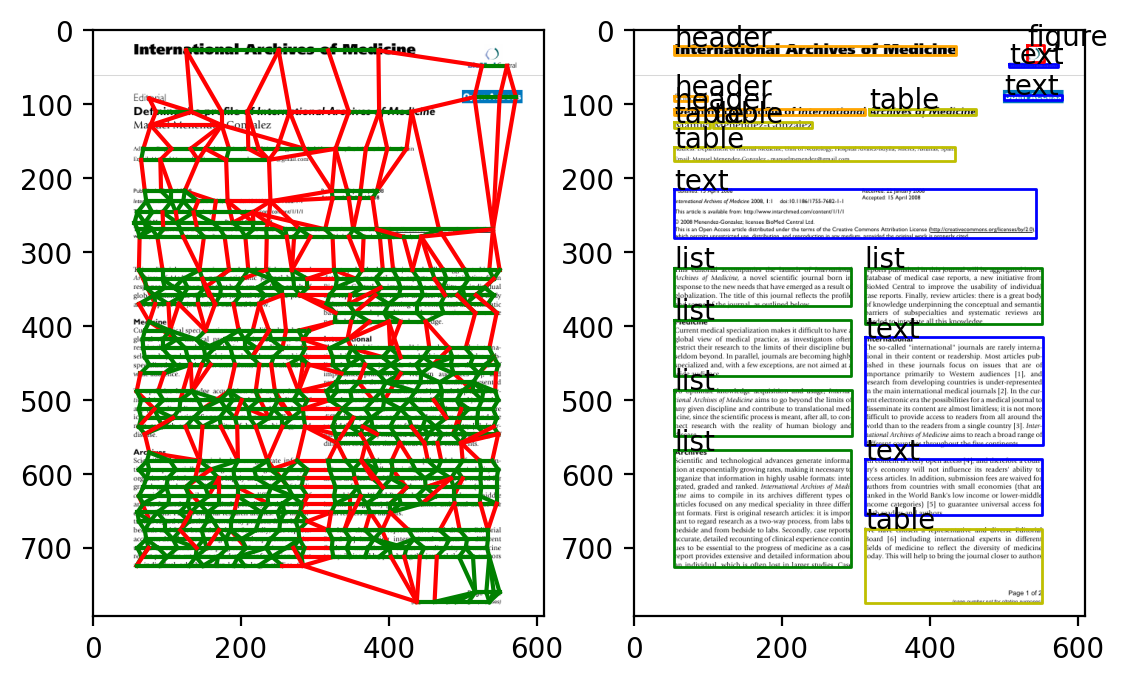

In [28]:
plot_file("./train_files_example/PMC2367690_00000.pdf", class_=True)

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 35


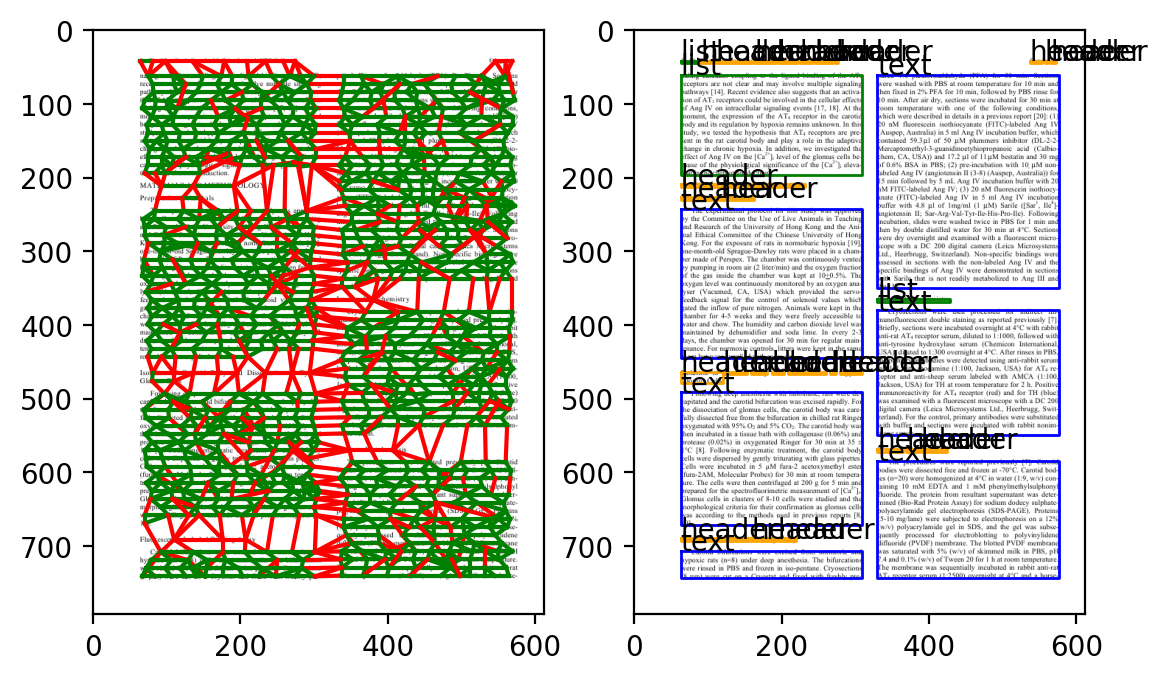

In [26]:
plot_file("./train_files_example/PMC2570565_00001.pdf", class_=True)

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 5


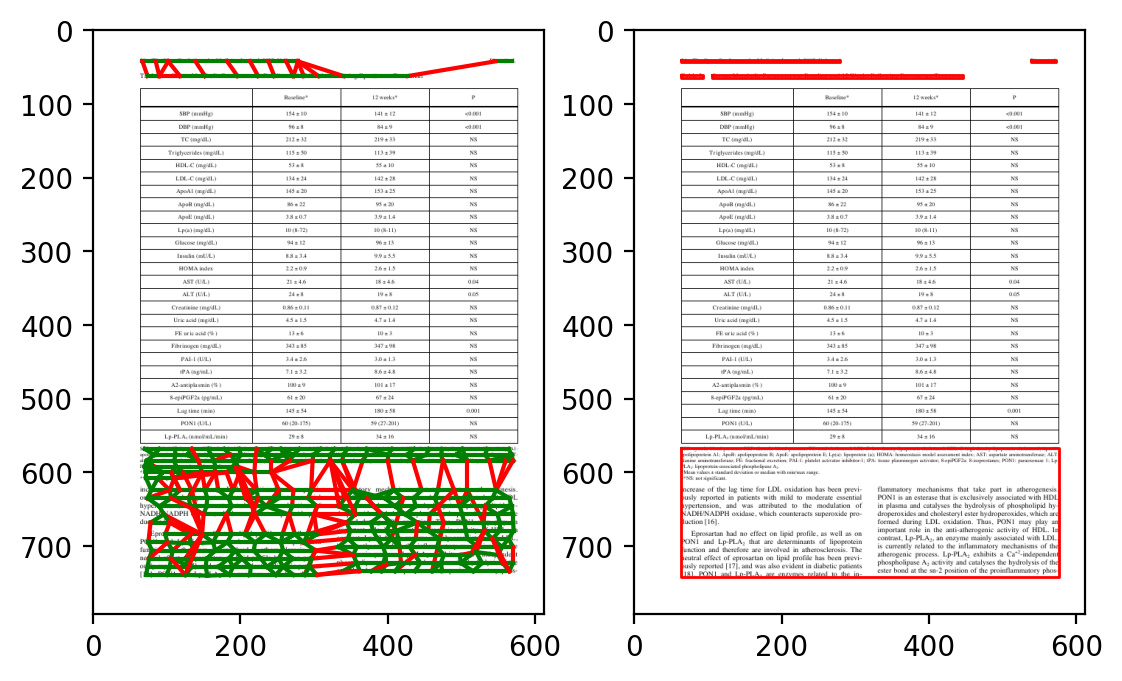

In [21]:
plot_file("./train_files_example/PMC2570567_00002.pdf")

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 16


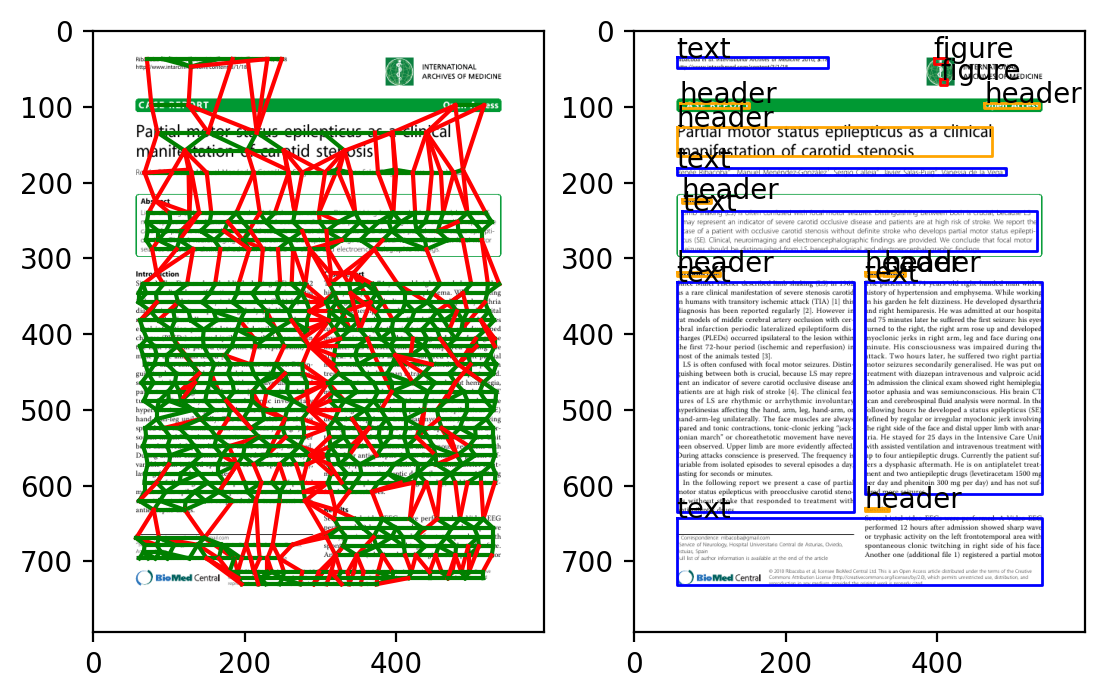

In [25]:
plot_file("./train_files_example/PMC2942812_00000.pdf", class_=True)

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 7


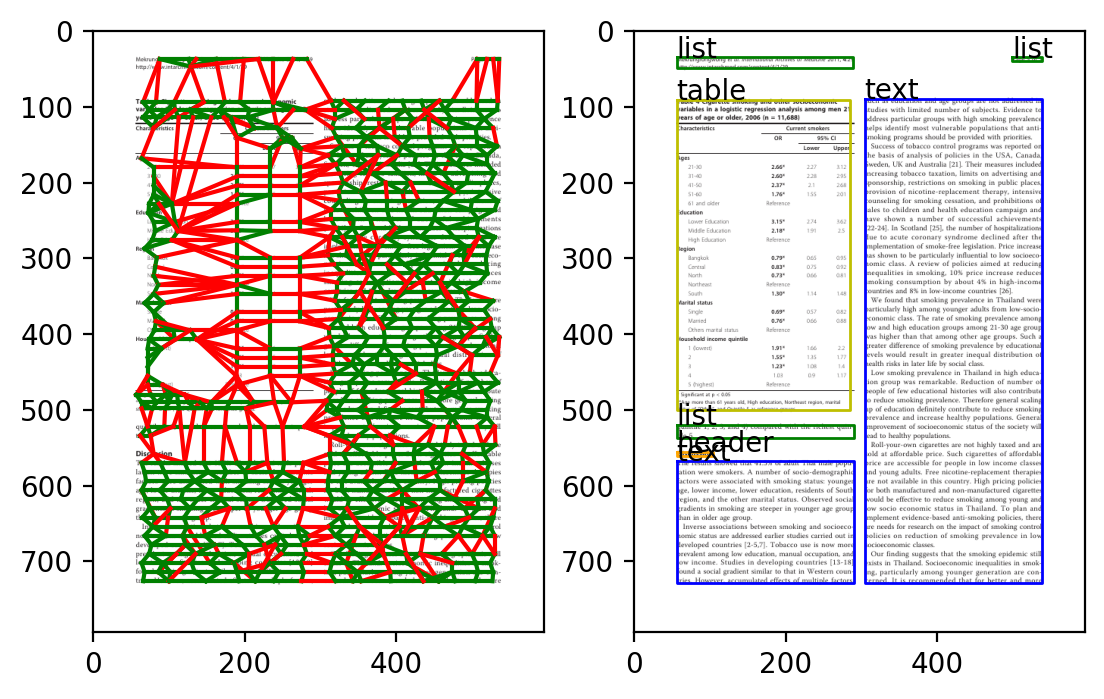

In [11]:
plot_file("./train_files_example/PMC3177771_00004.pdf", class_=True)

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 23


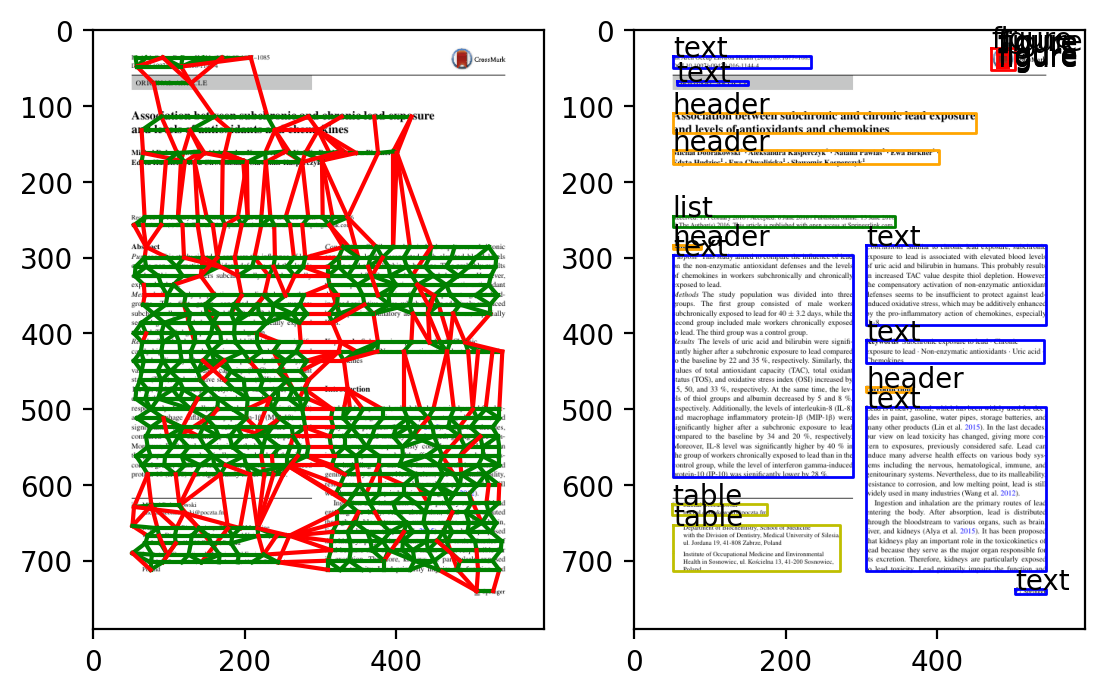

In [27]:
plot_file("./train_files_example/PMC5005401_00000.pdf", class_=True)

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:70: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  src = src.to_sparse_csr()


count blocks: 9


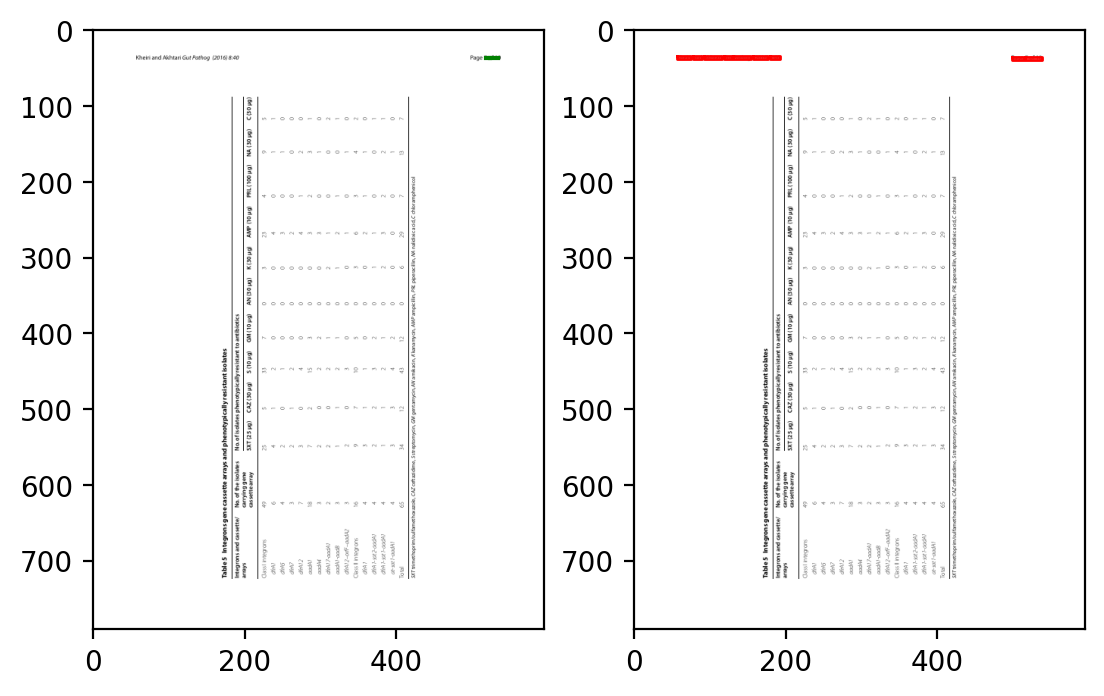

In [8]:
plot_file("./train_files_example/PMC5006490_00006.pdf")

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 36


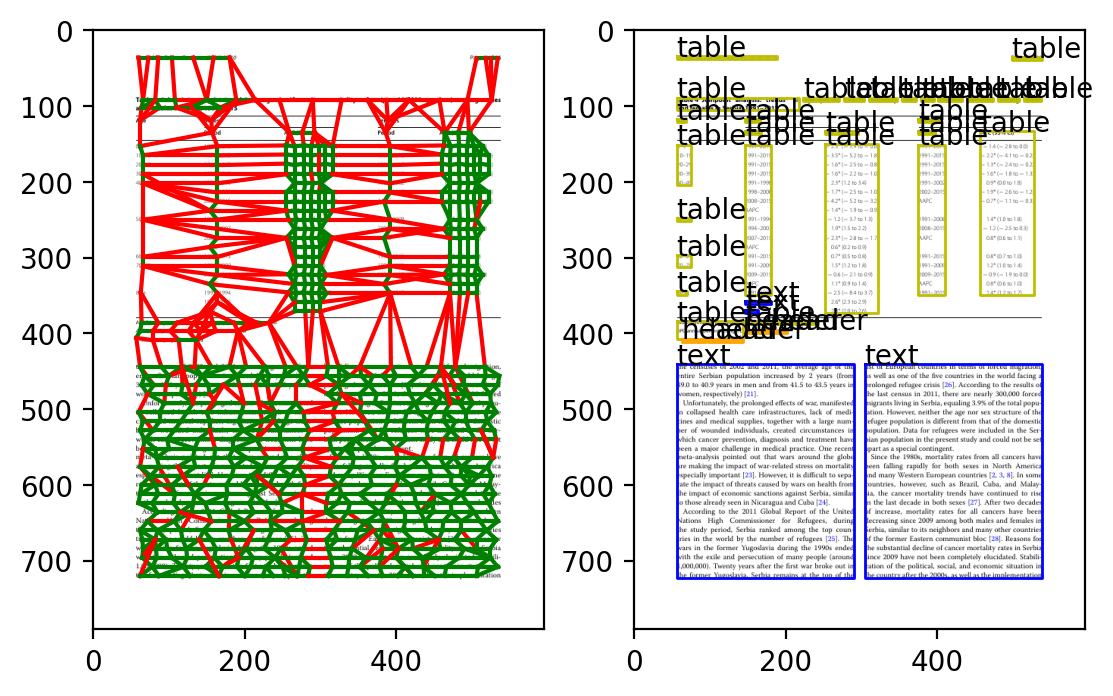

In [24]:
plot_file("./train_files_example/PMC5993142_00007.pdf", class_=True)

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 30


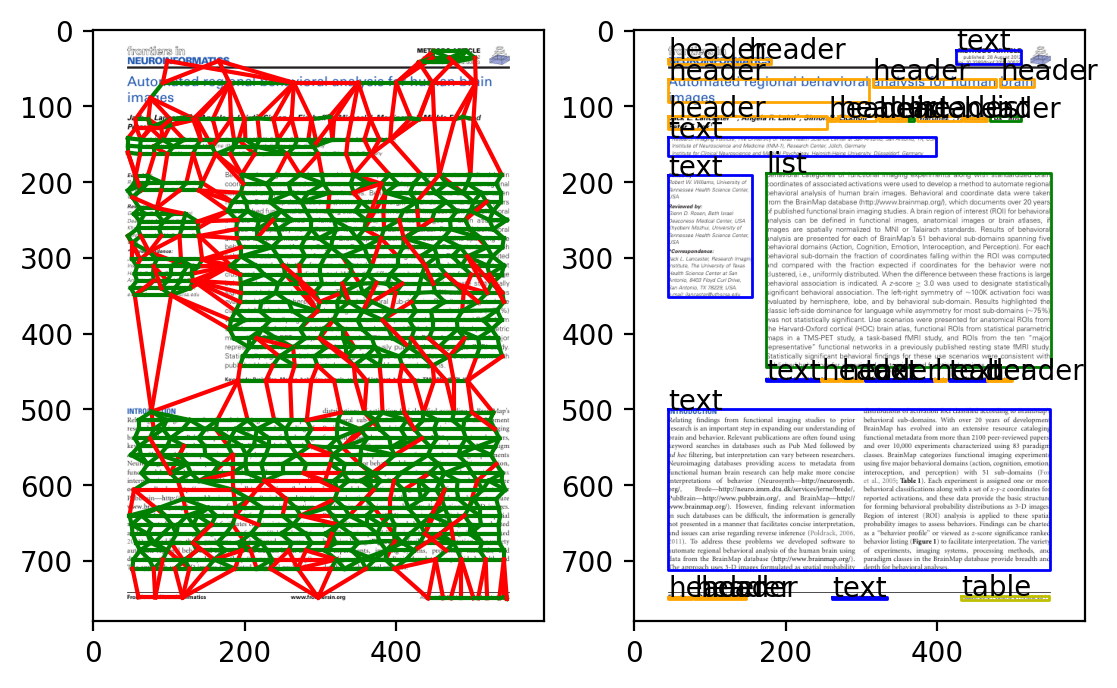

In [23]:
plot_file("./train_files_example/val_files/PMC3428588_00000.pdf", class_=True)

/Users/macbookair/program/python/PageR/env/lib/python3.9/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 5


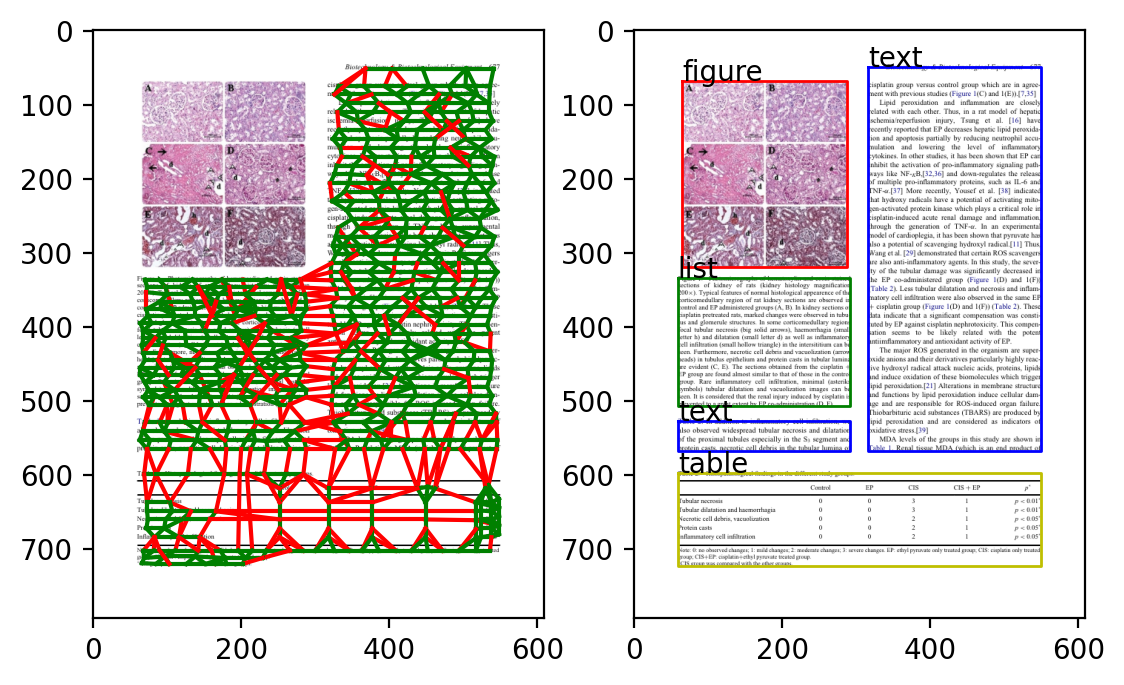

In [16]:
plot_file("./train_files_example/val_files/PMC4433950_00003.pdf", class_=True)